In [1]:
import sys

sys.path.append('..')

In [2]:
import numpy as np

maturity = 5.

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [3]:
from finance.discountfactor import ConstantRateDiscountFactor 

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [4]:
hurdle_rate = 0.1

In [5]:
def compute_varrho_ccp(loss_dfr, cva_t0_dfr, cva_t1_dfr, t0_, t1_, incl_cva):
    rho = loss_dfr.sum(axis=1) 
    
    if incl_cva:
        rho_tmp = discount(t1_) * cva_t1_dfr.sum(axis=1)
        rho_tmp -= discount(t0_) * cva_t0_dfr.sum(axis=1)
        
        rho += rho_tmp 
    
    return rho

In [6]:
import pandas as pd
import os

loss_path = './res/aggregated/loss_1y_ahead/'
cva_path = './res/aggregated/cva_ccp/'

df_times_path = './res/aggregated/default_times.csv'

In [7]:
df_times = pd.read_csv(df_times_path, header=0, index_col=0)

trans_df_times = df_times.transpose()

In [8]:
def compute_1y_ahead_varrho_ccp(times_cva_, shifted_times_cva_, incl_cva=True):
    varrho_ccp = dict()
    
    for t0_, t1_ in zip(times_cva_, shifted_times_cva_):
        cur_loss_int = "[%.2f, %.2f]" % (t0_, t1_)
        loss_path_ = os.path.join(loss_path, 'loss_%s.csv' % cur_loss_int)
        loss_ahead = pd.read_csv(loss_path_, index_col=0, header=0)
    
        cur_t0 = "%.2f" % t0_
        cva_t0_path = os.path.join(cva_path, 'cva_%s.csv' % cur_t0)
        cva_t0 = pd.read_csv(cva_t0_path, index_col=0, header=0)
    
        cur_t1 = "%.2f" % t1_
        cva_t1_path = os.path.join(cva_path, 'cva_%s.csv' % cur_t1)
        cva_t1 = pd.read_csv(cva_t1_path, index_col=0, header=0)
    
        col_names = ['all', 17, 9, 29, 26, 50, 4, 5, 13, 64]
        varrho_ccp_t0_t1 = {}
    
        for col in col_names:
            if col == 'all':
                varrho_ser = compute_varrho_ccp(loss_ahead, cva_t0, cva_t1, t0_, t1_, incl_cva)
            else:
                col = unicode(col)
                loss__ = loss_ahead.drop(col, 1)
                cva_t0__ = cva_t0.drop(col, 1)
                cva_t1__ = cva_t1.drop(col, 1)
            
                varrho_ser = compute_varrho_ccp(loss__, cva_t0__, cva_t1__, t0_, t1_, incl_cva)    
    
            varrho_ccp_t0_t1[col] = varrho_ser
        
        varrho_ccp[cur_loss_int] = pd.DataFrame(varrho_ccp_t0_t1)
    
    return varrho_ccp

In [9]:
varrho_ccp = compute_1y_ahead_varrho_ccp(times_cva, shifted_times_cva, incl_cva=True)

#varrho_ccp_time = pd.DataFrame({key: value['all'] for (key, value) in zip(times_cva, varrho_ccp.values())})

tmp_dict = {}
for t0, t1 in zip(times_cva, shifted_times_cva):
    str_interval = '[%.2f, %.2f]' % (t0, t1)
    tmp_dict[t0] = varrho_ccp[str_interval]['all']
    
varrho_ccp_time = pd.DataFrame(tmp_dict)

varrho_ccp_time.head()

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
0,0.105430,-0.004297,-0.003986,-0.003980,-0.003914,-0.002107,-0.000717,0.006876,0.007187,0.000000
1,-0.002220,-0.004051,-0.003376,0.053802,0.052160,0.010253,0.012620,0.000000,0.000000,0.000000
2,-0.002058,0.100675,0.101279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.005861,-0.003899,-0.002574,-0.005543,-0.003330,-0.000017,-0.000034,-0.000028,-0.000014,-0.000002
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns
sns.set_context('talk')

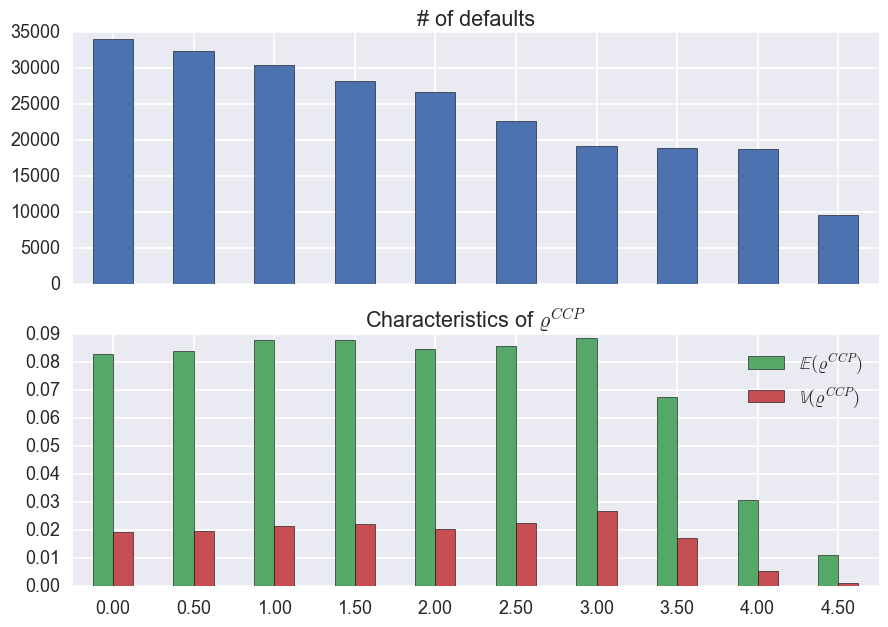

In [11]:
df_defaults_losses = pd.DataFrame(columns=['# of defaults', 
                                           r'$\mathbb{E}(\varrho^{CCP})$', 
                                           r'$\mathbb{V}(\varrho^{CCP})$'])

#defaults, e_losses, v_losses, s_losses = [pd.Series() for _ in xrange(4)]
defaults, e_losses, v_losses = [pd.Series() for _ in xrange(3)]

for t0, t1 in zip(times_cva, shifted_times_cva):
    index = (t0 <= trans_df_times) & (trans_df_times < t1)
    crt_df_defaults = trans_df_times[index]
    crt_df_defaults = crt_df_defaults.dropna(how='all')
    
    crt_df_defaults['sum'] = crt_df_defaults.count(axis=1, numeric_only=True)
    nb = crt_df_defaults['sum'].sum()
    
    key = '%.2f' % (t0)
    defaults[key] = nb
    
    index2 = index.loc[(index).any(axis=1)].index.values
    index2 = map(int, index2)
    crt_losses = varrho_ccp_time[t0][index2]
    
    e_losses[key] = crt_losses.mean()
    v_losses[key] = crt_losses.var()
    #k_losses[key] = crt_losses.skew()

df_defaults_losses['# of defaults'] = defaults
df_defaults_losses[r'$\mathbb{E}(\varrho^{CCP})$'] = e_losses
df_defaults_losses[r'$\mathbb{V}(\varrho^{CCP})$'] = v_losses
#df_defaults_losses[r'$\mathbb{S}(\varrho^{CCP})$'] = s_losses
    
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
df_defaults_losses['# of defaults'].plot.bar(ax=ax1)
ax1.set_title('# of defaults')

df_defaults_losses.drop('# of defaults', axis=1, inplace=True)
df_defaults_losses.plot.bar(ax=ax2, color=sns.color_palette()[1:4])
ax2.set_title(r'Characteristics of $\varrho^{CCP}$')

#plt.title(r'Number of defaults in $[t, t+1]$')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()

In [12]:
def plot_right_tail_loss_distrib(incl_cva):
    varrho_ccp = compute_1y_ahead_varrho_ccp(times_cva, shifted_times_cva, incl_cva=incl_cva)
    
    tmp_dict = {}
    for t0, t1 in zip(times_cva, shifted_times_cva):
        str_interval = '[%.2f, %.2f]' % (t0, t1)
        tmp_dict[t0] = varrho_ccp[str_interval]['all']
    
    varrho_ccp_time_ = pd.DataFrame(tmp_dict)

    palette = sns.color_palette('husl', len(varrho_ccp_time_.columns))
    sns.set_palette(palette)

    alpha = 0.9
    index = int(alpha * len(varrho_ccp_time_))

    alpha2 = 1.
    index_sup = int(alpha2 * len(varrho_ccp_time_))

    for t in varrho_ccp_time_.columns:
        crt_varrho = varrho_ccp_time_[t]
        crt_varrho = crt_varrho.sort_values(inplace=False)
        crt_varrho = crt_varrho.reset_index(drop=True)
    
        #crt_varrho.reset_index(drop=True).plot(label=t)
        
        plt.plot(crt_varrho.index[index:index_sup], crt_varrho.values[index:index_sup], label='%s y' % t)
        
        #print max(crt_varrho.values[index:index_sup])
        #print crt_varrho.index.values[index:]
        #print crt_varrho.values[index:]
    
    formatter_prob = FuncFormatter(lambda y, pos: "%.0f %%" % (y / 1000.))
    plt.gca().xaxis.set_major_formatter(formatter_prob)
    
    plt.title(r'Right tail distribution of $\varrho^{CCP}$')
    plt.legend(loc='best')
    plt.show()

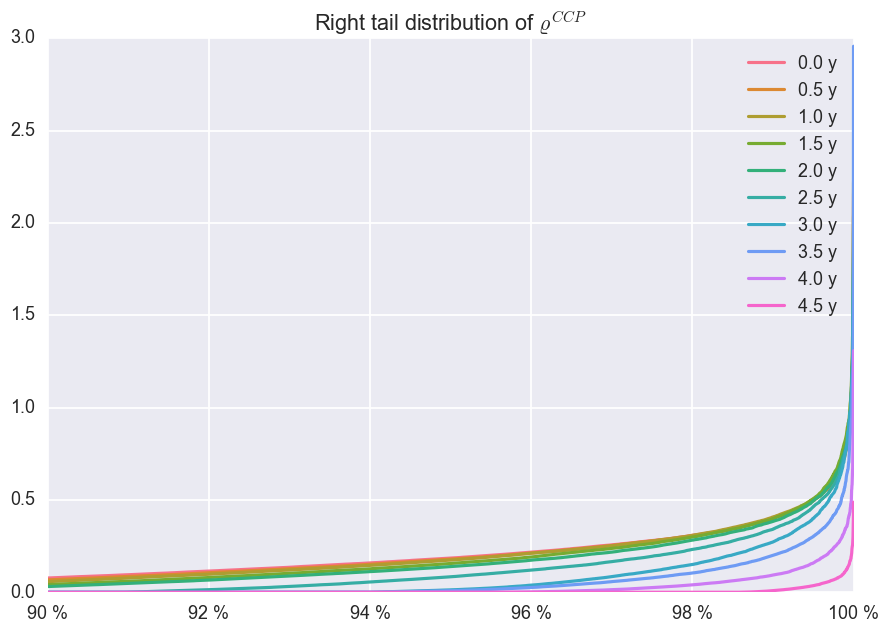

In [13]:
incl_cva = True
plot_right_tail_loss_distrib(incl_cva)

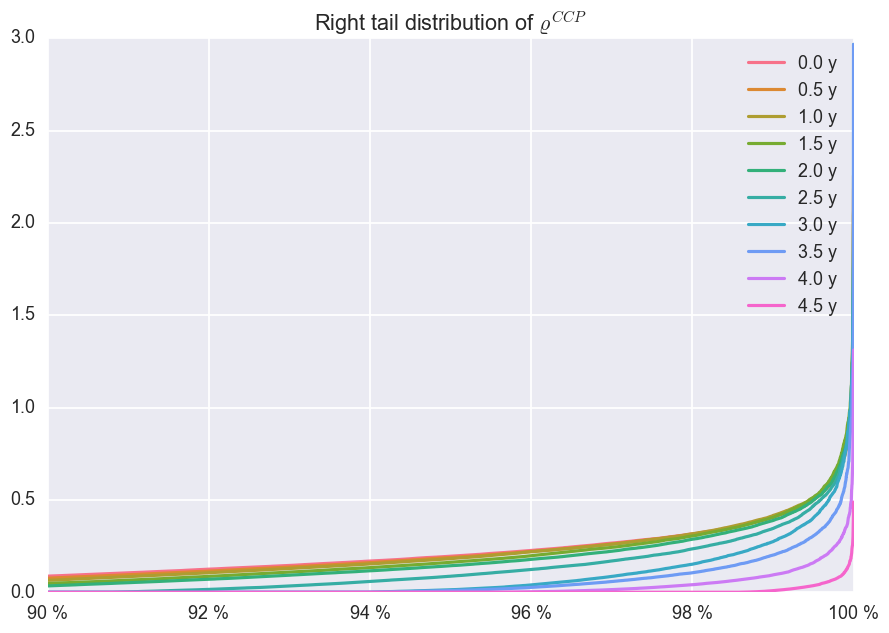

In [14]:
incl_cva = False
plot_right_tail_loss_distrib(incl_cva)